<a href="https://colab.research.google.com/github/Alexny1992/airline_flight_delay_prediction/blob/main/Facebook_Prophet_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install pyspark
!pip install prophet
!pip install mpld3==0.5.8

# New Section

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prophet as fbprophet
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, concat, col, lit, month, date_format
import os
import requests
from IPython.display import HTML
import mpld3
from mpld3 import plugins
from mpld3.utils import get_id
import collections

In [3]:
file_path = '/content/drive/MyDrive/Data_Analysis/Airline_Delay_Cause.csv'
try:
  df = SparkSession.builder.appName('Airline_Delay_Cause').getOrCreate()
  data = df.read.csv(file_path, header=True, inferSchema=True)
  print("File read successfully")
except Exception as e:
  print(f"Error reading file: {e}")
print(data)

File read successfully
DataFrame[year: int, month: int, carrier: string, carrier_name: string, airport: string, airport_name: string, arr_flights: double, arr_del15: double, carrier_ct: double, weather_ct: double, nas_ct: double, security_ct: double, late_aircraft_ct: double, arr_cancelled: double, arr_diverted: double, arr_delay: double, carrier_delay: double, weather_delay: double, nas_delay: double, security_delay: double, late_aircraft_delay: double]


In [4]:
data.show()

+----+-----+-------+-----------------+-------+--------------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+
|year|month|carrier|     carrier_name|airport|        airport_name|arr_flights|arr_del15|carrier_ct|weather_ct|nas_ct|security_ct|late_aircraft_ct|arr_cancelled|arr_diverted|arr_delay|carrier_delay|weather_delay|nas_delay|security_delay|late_aircraft_delay|
+----+-----+-------+-----------------+-------+--------------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+
|2024|    7|     9E|Endeavor Air Inc.|    ABE|Allentown/Bethleh...|       90.0|     29.0|     12.76|      3.06|   7.9|        0.0|            5.28|          7.0|         0.0|   1815.0|        925.0|        207.0|    321.0|    

In [5]:
data.describe().show()

+-------+------------------+-----------------+-------+--------------------+-------+--------------------+-----------------+------------------+-----------------+-----------------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|              year|            month|carrier|        carrier_name|airport|        airport_name|      arr_flights|         arr_del15|       carrier_ct|       weather_ct|           nas_ct|        security_ct|  late_aircraft_ct|     arr_cancelled|      arr_diverted|         arr_delay|     carrier_delay|     weather_delay|         nas_delay|    security_delay|late_aircraft_delay|
+-------+------------------+-----------------+-------+--------------------+-------+--------------------+-----------------+------------------+-----------------+-----------------+-----------------+-------------------+---------

In [6]:
unique_airports = data.select("airport", "airport_name" ).distinct()
print(unique_airports.show())

+-------+--------------------+
|airport|        airport_name|
+-------+--------------------+
|    HVN|New Haven, CT: Tw...|
|    BLV|Belleville, IL: S...|
|    PUW|Pullman, WA: Pull...|
|    LMT|Klamath Falls, OR...|
|    LWS|Lewiston, ID: Lew...|
|    TVC|Traverse City, MI...|
|    DRO|Durango, CO: Dura...|
|    IND|Indianapolis, IN:...|
|    HYA|Hyannis, MA: Cape...|
|    FCA|Kalispell, MT: Gl...|
|    ACK|Nantucket, MA: Na...|
|    SEA|Seattle, WA: Seat...|
|    TUL|Tulsa, OK: Tulsa ...|
|    HRL|Harlingen/San Ben...|
|    CPR|Casper, WY: Caspe...|
|    PBG|Plattsburgh, NY: ...|
|    HIB|Hibbing, MN: Rang...|
|    ISN|Williston, ND: Sl...|
|    GPT|Gulfport/Biloxi, ...|
|    SAF|Santa Fe, NM: San...|
+-------+--------------------+
only showing top 20 rows

None


In [7]:
unique_airports = data.select("carrier_name").distinct()
print(unique_airports.show(51,truncate=False))


+-----------------------------------------+
|carrier_name                             |
+-----------------------------------------+
|GoJet Airlines LLC d/b/a United Express  |
|Hawaiian Airlines Network                |
|Alaska Airlines Network                  |
|Endeavor Air Inc.                        |
|CommuteAir LLC dba CommuteAir            |
|Allegiant Air                            |
|Delta Air Lines Network                  |
|American Eagle Airlines Inc.             |
|SkyWest Airlines Inc.                    |
|Virgin America                           |
|PSA Airlines Inc.                        |
|Horizon Air                              |
|United Air Lines Inc.                    |
|American Airlines Network                |
|Piedmont Airlines                        |
|Air Wisconsin Airlines Corp              |
|Trans States Airlines                    |
|Compass Airlines                         |
|Republic Airline                         |
|Peninsula Airways Inc.         

In [8]:
carrier_name = 'JetBlue Airways'
airport_code = 'JFK'
df_filtered = data.filter((data['carrier_name'] == carrier_name) & (data['airport'] == airport_code))
print(df_filtered.show())

+----+-----+-------+---------------+-------+--------------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+
|year|month|carrier|   carrier_name|airport|        airport_name|arr_flights|arr_del15|carrier_ct|weather_ct|nas_ct|security_ct|late_aircraft_ct|arr_cancelled|arr_diverted|arr_delay|carrier_delay|weather_delay|nas_delay|security_delay|late_aircraft_delay|
+----+-----+-------+---------------+-------+--------------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+
|2024|    7|     B6|JetBlue Airways|    JFK|New York, NY: Joh...|     3198.0|   1016.0|    305.78|     18.31|285.38|       0.08|          406.46|         73.0|        17.0|  94990.0|      35325.0|       1522.0|  19613.0|           5

In [9]:
df = df_filtered.withColumn('ds', to_date(concat(col('year'),lit('-'),col('month'))))

In [56]:
df_filtered = df.withColumn('flight_ratio', col('arr_del15')/col('arr_flights')*100)
df_filtered = df_filtered.withColumnRenamed('flight_ratio', 'y')
df_filtered.show()

+----+-----+-------+---------------+-------+--------------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+----------+------------------+
|year|month|carrier|   carrier_name|airport|        airport_name|arr_flights|arr_del15|carrier_ct|weather_ct|nas_ct|security_ct|late_aircraft_ct|arr_cancelled|arr_diverted|arr_delay|carrier_delay|weather_delay|nas_delay|security_delay|late_aircraft_delay|        ds|                 y|
+----+-----+-------+---------------+-------+--------------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+----------+------------------+
|2024|    7|     B6|JetBlue Airways|    JFK|New York, NY: Joh...|     3198.0|   1016.0|    305.78|     18.31|285.38|       0.08|          406.

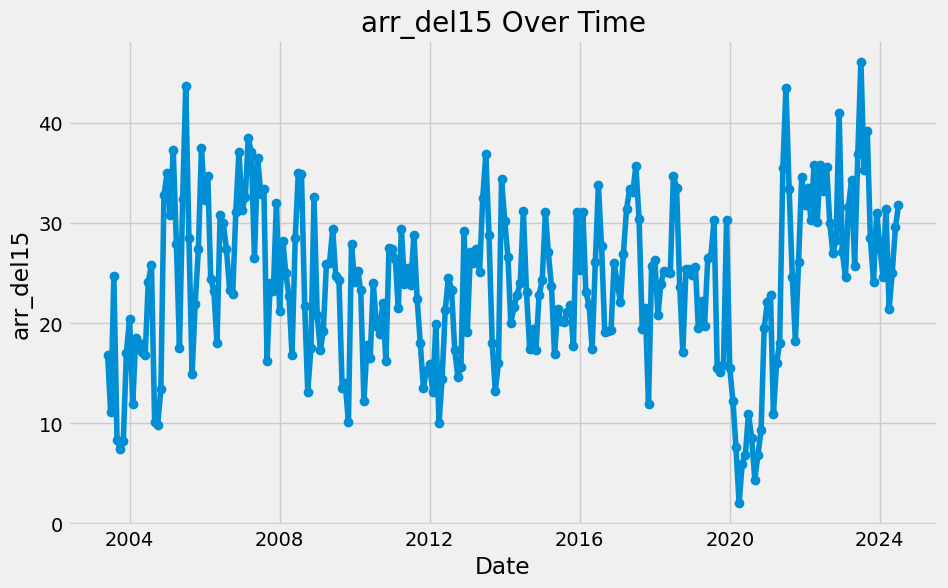

In [57]:
pandas_df = df_filtered.select('ds', 'y').toPandas()
pandas_df = pandas_df.sort_values(by='ds')


plt.figure(figsize=(10, 6))
plt.style.use('fivethirtyeight')
plt.plot(pandas_df['ds'], pandas_df['y'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('arr_del15')
plt.title('arr_del15 Over Time')
plt.show()

In [202]:
pandas_df2 = df.select('ds', 'arr_flights').toPandas()
pandas_df2 = pandas_df2.sort_values(by='ds')

x = pandas_df2['ds'] # Assuming 'ds' is your x-axis
y = pandas_df2['arr_flights'] # Assuming 'arr_flights' is your y-axis
labels = ['arr_flights']

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(pandas_df2['ds'], pandas_df2['arr_flights'])
line_collections = ax.plot(x,y, lw=1, alpha=.1)
interactive_legend = plugins.InteractiveLegendPlugin(line_collections, labels)
plugins.connect(fig, interactive_legend)
mpld3.display()

# Preparing Facebook Prophet Model

In [204]:
# Training and test split
test_days = 31
training_set = df_filtered.limit(df_filtered.count() - test_days)
test_set = df_filtered.tail(test_days)

training_set_pd = training_set.toPandas()
test_set_pd = training_set.toPandas()

# training_set = df_filtered.iloc[:-test_days, :]
# test_set = df_filtered.iloc[-test_days:, :]

In [250]:
m = fbprophet.Prophet(
    growth = 'linear',
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False,
    holidays = None,
    seasonality_mode = "additive",
    seasonality_prior_scale = 20.0,
    changepoint_prior_scale = 0.1
)
# m.add_regressor('arr_flights')
m.add_regressor('arr_del15')
# m.add_regressor('carrier_ct')
m.add_regressor('weather_ct')
# m.add_regressor('nas_ct')
# m.add_regressor('late_aircraft_ct')

m.fit(training_set_pd)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6m6oxmp/rie4dqrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6m6oxmp/ir43b1dt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92996', 'data', 'file=/tmp/tmpj6m6oxmp/rie4dqrn.json', 'init=/tmp/tmpj6m6oxmp/ir43b1dt.json', 'output', 'file=/tmp/tmpj6m6oxmp/prophet_model67hci2gj/prophet_model-20241021203300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:33:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [251]:
# Coefficient Regressor
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,arr_del15,additive,899.484305,0.019347,0.019347,0.019347
1,weather_ct,additive,11.630448,0.019043,0.019043,0.019043


In [254]:
# future dataFrame
future = m.make_future_dataframe(periods=test_days, freq='d')
df_filtered_pd = df_filtered.toPandas()
df_filtered_pd['ds'] = pd.to_datetime(df_filtered_pd['ds'])
df_filtered_pd
future = pd.merge(future, df_filtered_pd[[ 'ds', 'arr_del15',  'weather_ct']], on='ds', how= 'inner')
future.head()

,ds,arr_del15,weather_ct
0,2006-01-01,1086.0,21.22
1,2006-02-01,1104.0,20.72
2,2006-03-01,920.0,3.69
3,2006-04-01,892.0,3.65
4,2006-05-01,669.0,11.04


In [255]:
# Forcasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,arr_del15,...,weather_ct,weather_ct_lower,weather_ct_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-01-01,20.975608,23.592869,29.371460,20.975608,20.975608,5.667586,5.667586,5.667586,3.608580,...,0.182618,0.182618,0.182618,1.876388,1.876388,1.876388,0.0,0.0,0.0,26.643194
1,2006-02-01,20.971076,25.201108,30.876784,20.971076,20.971076,7.116716,7.116716,7.116716,3.956832,...,0.173096,0.173096,0.173096,2.986788,2.986788,2.986788,0.0,0.0,0.0,28.087793
2,2006-03-01,20.966983,18.124071,23.668184,20.966983,20.966983,-0.054025,-0.054025,-0.054025,0.396924,...,-0.151214,-0.151214,-0.151214,-0.299735,-0.299735,-0.299735,0.0,0.0,0.0,20.912958
3,2006-04-01,20.962451,18.168885,23.789833,20.962451,20.962451,-0.048364,-0.048364,-0.048364,-0.144801,...,-0.151975,-0.151975,-0.151975,0.248413,0.248413,0.248413,0.0,0.0,0.0,20.914088
4,2006-05-01,20.958066,13.022672,18.633601,20.958066,20.958066,-5.092216,-5.092216,-5.092216,-4.459256,...,-0.011244,-0.011244,-0.011244,-0.621716,-0.621716,-0.621716,0.0,0.0,0.0,15.865850


In [256]:
#Retrieving Prediction
prediction = forecast.yhat[-test_days:]
prediction.head()

,yhat
192,34.606396
193,35.318217
194,31.417400
195,35.497839
196,31.422590


In [257]:
#MAE RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
test_set_y = np.array([row['y'] for row in test_set])
mae = mean_absolute_error(test_set_y, prediction)
rmse = np.sqrt(mean_squared_error(test_set_y, prediction))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 11.557240825476294
RMSE: 13.814088923646691


In [258]:
#Visualization
from mpld3 import plugins


fig = m.plot(forecast)
line_collections = ax.plot([],[], lw=1, alpha=.1, label='arr_flights')
interactive_legend = plugins.InteractiveLegendPlugin(line_collections, labels=['arr_flights'])
plugins.connect(fig, interactive_legend)
mpld3.display()



In [200]:
fig = m.plot_components(forecast)
mpld3.display(fig)

# Cross Validation


In [213]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model = m,
                         horizon = '31 days',
                         initial = '1500 days',
                         parallel = 'processes')
df_cv.head()

INFO:prophet:Making 338 forecasts with cutoffs between 2010-02-10 12:00:00 and 2024-05-31 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x791f32433df0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6m6oxmp/hpo0dz2d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6m6oxmp/jbiq2r8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53027', 'data', 'file=/tmp/tmpj6m6oxmp/hpo0dz2d.json', 'init=/tmp/tmpj6m6oxmp/jbiq2r8f.json', 'output', 'file=/tmp/tmpj6m6oxmp/prophet_model092r419p/prophet_model-20241021184805.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:48:05 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6m6oxmp/vy5116th.json
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6m6oxmp/0_0myif8.json


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-03-01,22.309371,21.562211,23.133094,23.288709,2010-02-10 12:00:00
1,2010-03-01,22.309371,21.562211,23.133094,23.288709,2010-02-26 00:00:00
2,2010-04-01,13.306604,12.588594,14.031124,12.202937,2010-03-13 12:00:00
3,2010-04-01,13.306604,12.588594,14.031124,12.202937,2010-03-29 00:00:00
4,2010-05-01,17.854918,17.137420,18.571989,17.858106,2010-04-13 12:00:00


In [215]:
# Measure the error
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

print(mean_absolute_error(df_cv['y'], df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

1.8398688990787868
2.4825166244541594


# Turning Parameters

In [223]:
from sklearn.model_selection import ParameterGrid
param_Grid  = {
    'seasonality_prior_scale' : [5,10,20],
    'holiday_prior_scale' : [5,10,20],
    'changepoint_prior_scale': [0.01, 0.05, 0.1]
}
grid = ParameterGrid(param_Grid)
list(grid)[:3]

[{'changepoint_prior_scale': 0.01,
  'holiday_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holiday_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holiday_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [229]:
#hyperparameter
rmse = []

#loop
for params in grid:
  #model
  m = fbprophet.Prophet(growth = 'linear',
              yearly_seasonality = True,
              weekly_seasonality = True,
              daily_seasonality = True,
              seasonality_mode = 'additive',
              seasonality_prior_scale= params['seasonality_prior_scale'],
              changepoint_prior_scale= params['changepoint_prior_scale']
              )
  m.add_regressor('arr_del15')
  m.add_regressor('weather_ct')

  m.fit(training_set_pd)
  #Cross Validation
  df_cv = cross_validation(model = m,
                           horizon = '31 days',
                           initial = '1500 days',
                           parallel = 'processes')
  #Measure the error
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))

  #store the results
  rmse.append(error)

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] start processing
20:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6m6oxmp/5wcyyrb7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6m6oxmp/sloi_nxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41436', 'data', 'file=/tmp/tmpj6m6oxmp/5wcyyrb7.json', 'init=/tmp/tmpj6m6oxmp/sloi_nxx.json', 'output', 'file=/tmp/tmpj6m6oxmp/prophet_model_qrbtd1j/prophet_model-20241021202033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6m6oxmp/9ap

In [230]:
best_params = list(grid)[np.argmin(rmse)]
best_params

{'changepoint_prior_scale': 0.1,
 'holiday_prior_scale': 5,
 'seasonality_prior_scale': 20}